In [6]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import xgboost as xgb

/Users/hongta/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data

In [8]:
DATASET_PATH = "./dataset/UCI HAR Dataset/"

In [9]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

In [10]:
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        with open(signal_type_path, "r") as f:
            X_signals.append(
                [np.array(serie, dtype=np.float32)
                    for serie in [row.replace('  ', ' ').strip().split(' ') for row in f]]
            )
    return np.transpose(X_signals, (1, 2, 0))

def load_y(y_path):

    # Read dataset from disk, dealing with text file's syntax
    with open(y_path, "r") as f:
        y = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in f
            ]], 
            dtype=np.int32
        )
            
    y = y.reshape(-1,)
    # Substract 1 to each output class for friendly 0-based indexing 
    return y - 1

In [11]:
X_train_signals_paths = [
    DATASET_PATH + "train/Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + "test/Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

In [12]:
har_X_train = load_X(X_train_signals_paths)
har_X_test = load_X(X_test_signals_paths)

In [13]:
y_train_path = DATASET_PATH + "train/y_train.txt"
y_test_path = DATASET_PATH + "test/y_test.txt"

In [14]:
har_y_train = load_y(y_train_path)
har_y_test = load_y(y_test_path)

## Prepare data

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(har_X_train, har_y_train, random_state=42)

In [16]:
X_train.shape

(5514, 128, 9)

In [17]:
seq_len = X_train.shape[1]
n_channels = X_train.shape[2]

In [18]:
X_train = X_train.reshape(-1, seq_len * n_channels)
har_X_test = har_X_test.reshape(-1, seq_len * n_channels)

In [19]:
X_train.shape

(5514, 1152)

## Hyperparameters

In [20]:
batch_size = 60
n_classes = 6

num_round = 10

#XGBClassifier
learning_rate = 0.01
n_estimators=100
max_depth=5

In [21]:
dtrain  = xgb.DMatrix(X_train, label=y_train)

In [22]:
dtrain.num_row

<bound method DMatrix.num_row of <xgboost.core.DMatrix object at 0x114720b70>>

## the model

In [23]:
from xgboost import XGBClassifier

In [24]:
cls = XGBClassifier(learning_rate=learning_rate, 
                    max_depth=max_depth,
                    n_estimators=n_estimators)
cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [25]:
y_pred = cls.predict(har_X_test)


In [26]:
accuracy = accuracy_score(har_y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.63%


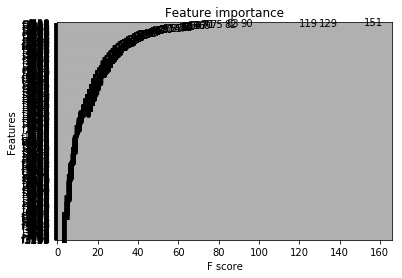

In [27]:
from xgboost import plot_importance
plot_importance(cls)
plt.show()

## Use GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [29]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)
param_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3],
    "max_depth": [1, 3, 5, 7, 9],
    "n_estimators": [50, 80, 100, 150, 200]
}

grid_search = GridSearchCV(cls, 
                           param_grid,
                           scoring="neg_log_loss",
                           n_jobs=-1,
                           cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

KeyboardInterrupt: 